In [1]:
# Suppression des warnings
import warnings
# warnings.filterwarnings('ignore')

# Importation des bibliothèques
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, r2_score, make_scorer, mean_squared_error
from sklearn import svm, linear_model
from sklearn.tree import DecisionTreeRegressor

from scipy.stats import f_oneway
from scipy.stats import pearsonr, kendalltau, spearmanr

%matplotlib inline

In [2]:
# Lecture des datas
bike_df = pd.read_csv('bike.csv')

bike_df = bike_df.drop_duplicates()
print('Taille du df : ', bike_df.shape)

bike_df.head()

Taille du df :  (17379, 8)


,dteday,hr,weathersit,hum,windspeed,temp,atemp,cnt
0,2011-01-01,0,clear,0.81,0.0,3.28,3.0014,16
1,2011-01-01,1,clear,0.80,0.0,2.34,1.9982,40
2,2011-01-01,2,clear,0.80,0.0,2.34,1.9982,32
3,2011-01-01,3,clear,0.75,0.0,3.28,3.0014,13
4,2011-01-01,4,clear,0.75,0.0,3.28,3.0014,1


- La variable cible : **cnt**
- Les variables explicatives sont toutes les autres.


# Exploration des données

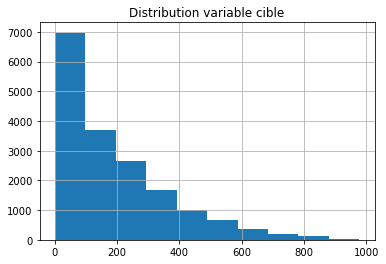

In [3]:
bike_df['cnt'].hist()
plt.title('Distribution variable cible');

In [4]:
display(bike_df.info())
display(bike_df.describe())
display(bike_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 0 to 17378
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   hr          17379 non-null  int64  
 2   weathersit  17379 non-null  object 
 3   hum         17379 non-null  float64
 4   windspeed   17379 non-null  float64
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   cnt         17379 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.2+ MB


None

,hr,hum,windspeed,temp,atemp,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,11.546752,0.627229,12.736540,15.358397,15.401157,189.463088
std,6.914405,0.192930,8.196795,9.050138,11.342114,181.387599
min,0.000000,0.000000,0.000000,-7.060000,-16.000000,1.000000
25%,6.000000,0.480000,7.001500,7.980000,5.997800,40.000000
50%,12.000000,0.630000,12.998000,15.500000,15.996800,142.000000
75%,18.000000,0.780000,16.997900,23.020000,24.999200,281.000000
max,23.000000,1.000000,56.996900,39.000000,50.000000,977.000000


dteday        0
hr            0
weathersit    0
hum           0
windspeed     0
temp          0
atemp         0
cnt           0
dtype: int64

# Transformation des données


In [5]:
def day_of_the_week(date) :
    """
    A partir d'une date donnée dans un df, on sort le jour de la semaine
    """
    return pd.to_datetime(date).day_name()

# Création d'une colonne avec le jour de la semaine
days = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
bike_df['weekday'] = bike_df['dteday'].apply(day_of_the_week)
bike_df['weekday'] = bike_df['weekday'].replace(days)

# Création d'une colonne pour le weekend (1=True, 0=False)
bike_df['is_weekend'] = bike_df['weekday'].apply(lambda x: 1 if (x >= 6) else 0)

# Création des colonnes year, month et day
bike_df['year'] = pd.DatetimeIndex(bike_df['dteday']).year
bike_df['month'] = pd.DatetimeIndex(bike_df['dteday']).month
bike_df['day'] = pd.DatetimeIndex(bike_df['dteday']).day

bike_df = bike_df[['year', 'month', 'day', 'hr',
                   'weekday', 'is_weekend', 'weathersit',
                   'hum', 'windspeed', 'temp', 'atemp', 'cnt']]

bike_df.head()

,year,month,day,hr,weekday,is_weekend,weathersit,hum,windspeed,temp,atemp,cnt
0,2011,1,1,0,6,1,clear,0.81,0.0,3.28,3.0014,16
1,2011,1,1,1,6,1,clear,0.80,0.0,2.34,1.9982,40
2,2011,1,1,2,6,1,clear,0.80,0.0,2.34,1.9982,32
3,2011,1,1,3,6,1,clear,0.75,0.0,3.28,3.0014,13
4,2011,1,1,4,6,1,clear,0.75,0.0,3.28,3.0014,1


In [6]:
weathersit = {'clear': 1, 'cloudy': 2, 'snowy': 3, 'rainy': 4}
bike_df['weathersit'] = bike_df['weathersit'].replace(weathersit)
bike_df.head()

,year,month,day,hr,weekday,is_weekend,weathersit,hum,windspeed,temp,atemp,cnt
0,2011,1,1,0,6,1,1,0.81,0.0,3.28,3.0014,16
1,2011,1,1,1,6,1,1,0.80,0.0,2.34,1.9982,40
2,2011,1,1,2,6,1,1,0.80,0.0,2.34,1.9982,32
3,2011,1,1,3,6,1,1,0.75,0.0,3.28,3.0014,13
4,2011,1,1,4,6,1,1,0.75,0.0,3.28,3.0014,1


# Visualisation

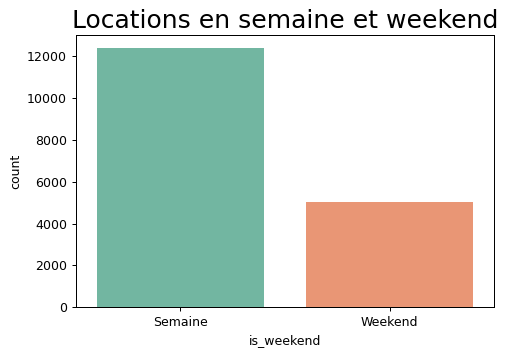

In [7]:
plt.figure(dpi=90)
plt.title('Locations en semaine et weekend', fontsize=20)
ax = sns.countplot(x=bike_df['is_weekend'], palette="Set2")
ax.set_xticklabels({'Semaine': 1, 'Weekend': 0})
plt.show()

- Les locations sont plus nombreuse en semaine. Cela s'explique par le fait que les gens louent des vélos pour leurs activités quotidiennes

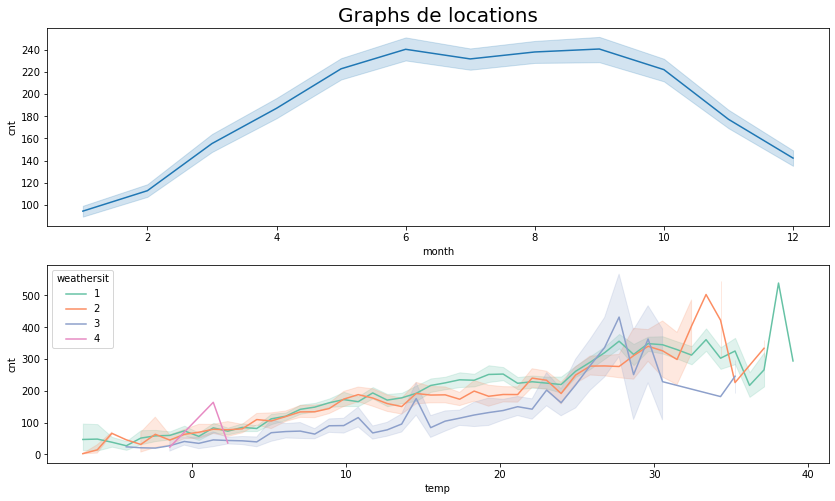

In [8]:
# Graphs du nb de location de vélos en fonction du mois puis de la température
plt.figure(figsize=(14,8))
ax = plt.subplot(211)
ax.set_title("Graphs de locations", fontsize=20)
sns.lineplot(x='month', y='cnt', data=bike_df)
plt.subplot(212)
sns.lineplot(x='temp', y='cnt', hue='weathersit', data=bike_df, palette="Set2")
plt.show();

- Pendant les beaux mois (~ juin à ~ septembre), le nombre de locations augmente
- Plus la température augmente, plus le nombre de location augmente également
- En cas de puie, si la température est bonne, les locations augmentent également

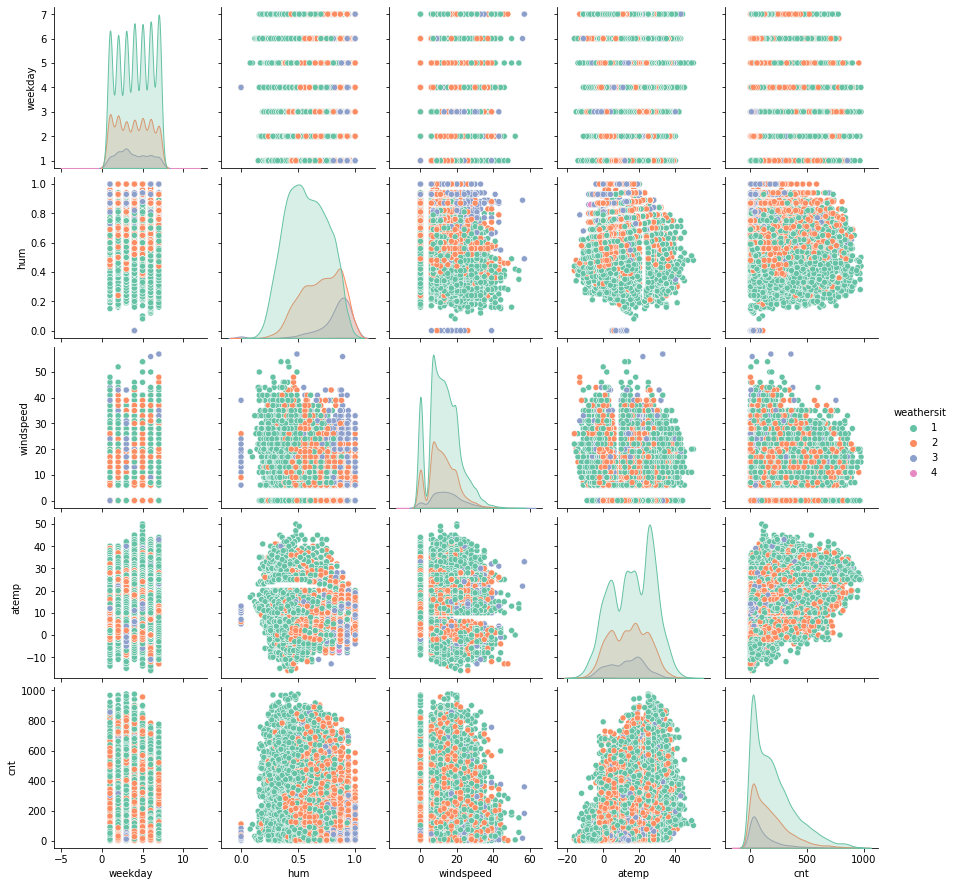

In [9]:
# Visualisation des features relatives à la météo
sns.pairplot(bike_df[["weekday", "hum", "windspeed", 
                      "atemp", "weathersit", "cnt"]], 
                      hue="weathersit",
                      palette="Set2");


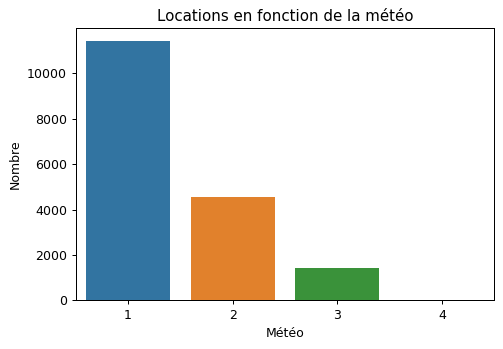

cnt                        
           min  max        mean  count
weathersit                            
1            1  977  204.869272  11413
2            1  957  175.165493   4544
3            1  891  111.579281   1419
4           23  164   74.333333      3

In [10]:
# Locations en fonction de la météo
plt.figure(dpi=90)
plt.title("Locations en fonction de la météo")
# sns.barplot(x='weathersit', y='cnt', data=bike_by_day)
sns.countplot(x='weathersit', data=bike_df)
plt.ylabel("Nombre")
plt.xlabel("Météo")
plt.show();

bike_df[['weathersit', 'cnt']].groupby(['weathersit']).agg(['min','max','mean','count'])

In [11]:
bike_df.head()

,year,month,day,hr,weekday,is_weekend,weathersit,hum,windspeed,temp,atemp,cnt
0,2011,1,1,0,6,1,1,0.81,0.0,3.28,3.0014,16
1,2011,1,1,1,6,1,1,0.80,0.0,2.34,1.9982,40
2,2011,1,1,2,6,1,1,0.80,0.0,2.34,1.9982,32
3,2011,1,1,3,6,1,1,0.75,0.0,3.28,3.0014,13
4,2011,1,1,4,6,1,1,0.75,0.0,3.28,3.0014,1


In [12]:
# Variables continues et catégorielles
continuous = ['cnt', 'atemp', 'temp', 'windspeed', 'hum']
categorials = ['year', 'month', 'day', 'hr', 'weekday', 'is_weekend', 'weathersit']


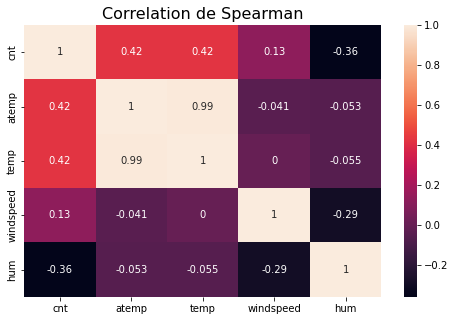

In [13]:
def correlation(df, name, fct):
    corr_ = pd.DataFrame(df.corr(method = name))
    #corr_ = corr_.drop('Unnamed: 0', axis = 0).drop('Unnamed: 0', axis = 1)

    for col in corr_.columns :
        for ligne in corr_.index :
            #if ligne == col :
                #corr_[col].loc[ligne] = None
            if fct(df[col], df[ligne])[1] > 0.05 :
                corr_[col].loc[ligne] = 0.0
    return corr_

# Etude de la correlation entre les variables
# Correlation de Spearman

corr_spearman = correlation(bike_df[continuous], 'spearman', spearmanr)

plt.figure(figsize=(8,5))
sns.heatmap(corr_spearman, annot=True, fmt='.2g')
plt.title('Correlation de Spearman', fontsize=16);

In [14]:
# Filtrage des colonnes qui ont une corrélation > 0.4 avec la target
# (Pas de variable avec une corrélation > 0.5)
corr_spearman['cnt'][abs(corr_spearman['cnt']) > 0.4]

cnt      1.000000
atemp    0.423258
temp     0.423330
Name: cnt, dtype: float64

**Variables continue retenues** : temp & atemp

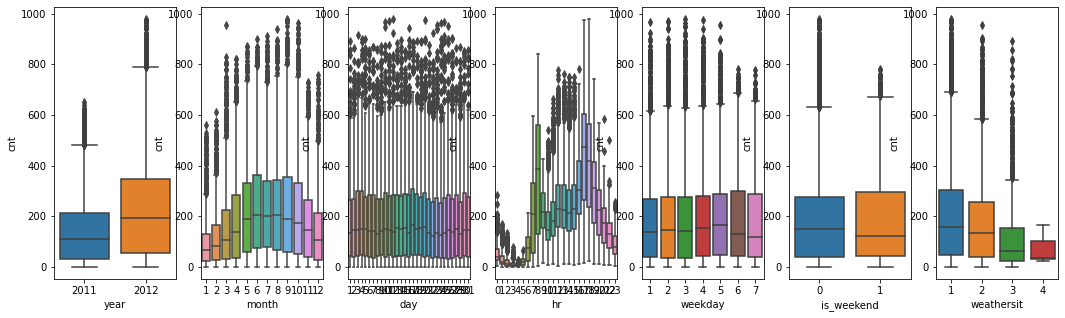

In [15]:
# Boxplots pour analyse entre les variables catégorielles et la variable cible

fig, axs = plt.subplots(ncols=len(categorials), figsize=(18,5))
for preds, i in zip(categorials, range(len(categorials))):   
    sns.boxplot(x=preds, y='cnt', data=bike_df, ax=axs[i])

- Les variables catégorielles sont bien correlées avec la target

# Test ANOVA (utilisé pour vérifier la relation entre une variable continue et une variable catégorielle)

- Hypothèse (H0): Pas de relation entre les variables
- Résultat : Probabilité que H0 soit vérifié


In [16]:
# Fonction Anova
def Anova(data, target, cat_list):
    
    # Liste vide
    m_list = []
    
    print('##### Résultats ANOVA #####\n')
    for predictor in cat_list:
        cat_group = data.groupby(predictor)[target].apply(list)
        results = f_oneway(*cat_group)
        
        # Si la p-value < 0.05, H0 est rejeté
        if (results[1] < 0.05):
            print(predictor, 'est correlée avec', target, '| p-value :', results[1])
            m_list.append(predictor)
        else:
            print(predictor, 'N\'EST PAS corrélée avec', target, '| p-value :', results[1])
    
    return(m_list)
    

In [17]:
Anova(data=bike_df, target='cnt', cat_list=categorials)

##### Résultats ANOVA #####

year est correlée avec cnt | p-value : 7.213184208630547e-247
month est correlée avec cnt | p-value : 5.505684936484358e-284
day N'EST PAS corrélée avec cnt | p-value : 0.6602612736151896
hr est correlée avec cnt | p-value : 0.0
weekday est correlée avec cnt | p-value : 0.0018990310434750582
is_weekend est correlée avec cnt | p-value : 0.009404636151633445
weathersit est correlée avec cnt | p-value : 1.7347820521803117e-81


['year', 'month', 'hr', 'weekday', 'is_weekend', 'weathersit']

# Sélection des colonnes finales

In [18]:
selection = ['year', 'month', 'hr', 'weekday', 'is_weekend', 'weathersit']

datas_ml = bike_df[selection]
datas_ml.head()

,year,month,hr,weekday,is_weekend,weathersit
0,2011,1,0,6,1,1
1,2011,1,1,6,1,1
2,2011,1,2,6,1,1
3,2011,1,3,6,1,1
4,2011,1,4,6,1,1


In [19]:
# Backup de ce df
datas_ml = datas_ml.drop(['year'], axis=1)
datas_ml.to_pickle('DataForML.pkl')
# print('Fichier Pickle pour les datas du ML sauvegardé ici :',os.getcwd())

In [20]:
# Traitement des variables nominales
datas_df_numeric = pd.get_dummies(datas_ml)

# Ajout de la target
datas_df_numeric['cnt'] = bike_df['cnt']
datas_df_numeric.to_pickle('DataForML.pkl')
datas_df_numeric.head()

,month,hr,weekday,is_weekend,weathersit,cnt
0,1,0,6,1,1,16
1,1,1,6,1,1,40
2,1,2,6,1,1,32
3,1,3,6,1,1,13
4,1,4,6,1,1,1


# Standardisation / Normalisation

In [21]:
# Séparation des variables
target = 'cnt'
# variables = ['month', 'hr', 'weekday', 'is_weekend', 'weathersit']
variables = ['hr', 'month', 'weekday', 'is_weekend', 'weathersit']

X = datas_df_numeric[variables].values
y = datas_df_numeric[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X.shape, y.shape)


(17379, 5) (17379,)


In [22]:
"""
scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)

X = scaler_fit.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
"""

'\nscaler = MinMaxScaler()\nscaler_fit = scaler.fit(X)\n\nX = scaler_fit.transform(X)\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nprint(X_train.shape, X_test.shape, y_train.shape, y_test.shape)\n'

In [23]:
# Initialisation de plusieurs modèles
models = {"Lasso": Lasso(),
          # "ElasticNet": ElasticNet(),
          # "SVR Linear": svm.SVR(kernel='linear'),
          "SVR Rbf": svm.SVR(kernel='rbf'),
          # "RidgeRegression": linear_model.Ridge(),
          "LinearRegression": LinearRegression(),
          "DecisionsTree": DecisionTreeRegressor()}

results = []


for model_name, model in models.items():
    fitted_model = model.fit(X_train, np.ravel(y_train, order='C'))
    # results[model_name] = model.score(X_train, y_train)
    results.append(fitted_model)
    
with open('All_Models.pkl', 'wb') as fileWriteStream:
    pickle.dump(results, fileWriteStream)
    fileWriteStream.close()

print('Les modèles sont sauvegardés ici :',os.getcwd())
results

print(results)

Les modèles sont sauvegardés ici : /home/remy/Desktop/Projet/notebook
[Lasso(), SVR(), LinearRegression(), DecisionTreeRegressor()]


In [24]:
for r in results:
    print(r.score(X_train, y_train))

0.1876745536378711
0.3598075751220794
0.18811396534413083
0.8642125675221449


- Le modèle d'arbre de décision obtient les meilleurs résultats

R2:  0.7960203938169057


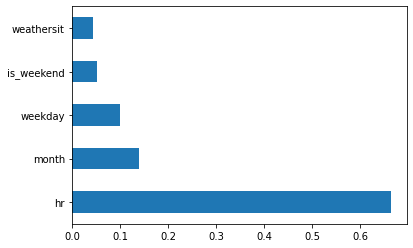

In [25]:
dt_model = DecisionTreeRegressor(max_depth=10, criterion='squared_error')

dt = dt_model.fit(X_train, y_train)
pred = dt.predict(X_test)

r2_value = r2_score(y_train, dt.predict(X_train))
print('R2: ', r2_value)

feature_importances = pd.Series(dt.feature_importances_, index=variables)
feature_importances.nlargest(10).plot(kind='barh');


# Model final
- Test sur les données complètes

In [26]:
# On retient uniquement les variables indispensables
variables = ['hr', 'month', 'weekday', 'is_weekend', 'weathersit']

X = datas_df_numeric[variables].values
y = datas_df_numeric[target].values

scaler = MinMaxScaler()
scaler_fit = scaler.fit(X)

X = scaler_fit.transform(X)

print(X.shape, y.shape)

(17379, 5) (17379,)


In [27]:
with open('MinMaxScaler.pkl', 'wb') as fileWriteStream:
    pickle.dump(scaler_fit, fileWriteStream)
    fileWriteStream.close()
    
print('Le MinMaxScaler est sauvegardé ici :',os.getcwd())

scaler_fit

Le MinMaxScaler est sauvegardé ici : /home/remy/Desktop/Projet/notebook


MinMaxScaler()

In [28]:
# Tuning des hyperparamètres

parameters = {"criterion": ["squared_error","absolute_error"],
              "min_samples_split": [10,20,40],
              "max_depth": [2,6,8],
              "min_samples_leaf": [20,40,100],
              "max_leaf_nodes": [5,20,100]}

dt_reg = DecisionTreeRegressor(max_depth=5, criterion='squared_error')

dt = dt_reg.fit(X_train, y_train)
pred = dt.predict(X_test)

tuning_model = GridSearchCV(dt,
                            param_grid=parameters,
                            scoring='r2', cv=5)


- Opération très longue
  - Calcul des hyperparamètres déjà effectué

In [29]:

# tuning_model.fit(X,y)



In [30]:
# print(tuning_model.best_params_)
# print(tuning_model.best_score_)

In [31]:
# Les paramètres idéaux sont les suivants

tuned_model = DecisionTreeRegressor(criterion='squared_error',
                                    max_depth=10,
                                    max_leaf_nodes=100,
                                    min_samples_leaf=20,
                                    min_samples_split=10)

tuned_model.fit(X_train, y_train)
tuned_pred = tuned_model.predict(X_test)


In [32]:
final_dt_model = tuned_model.fit(X,y)

# r2_score(y_test, tuned_pred)

In [33]:
# Sauvegarde du fichier final
with open('Final_DT_Model.pkl', 'wb') as fileWriteStream:
    pickle.dump(tuned_model, fileWriteStream)
    fileWriteStream.close()
    
print('Le modèle de prédiction final est sauvegardé ici :',os.getcwd())


Le modèle de prédiction final est sauvegardé ici : /home/remy/Desktop/Projet/notebook


In [34]:
score = r2_score(y_test, tuned_pred)
print(score)

0.74531945458244


In [35]:

def FunctionPredictResult(InputData):
    Num_Inputs = InputData.shape[0]
    datas_ml = pd.read_pickle('DataForML.pkl')

    # InputData = InputData.append(datas_ml) > deprecated
    InputData = pd.concat([InputData, datas_ml])
    
    InputData = pd.get_dummies(InputData)

    Predictors = ['hr', 'month', 'weekday', 'is_weekend', 'weathersit']
    #['hr', 'is_weekend', 'year', 'month', 'weekday']
    
    X = InputData[Predictors].values[0:Num_Inputs]
    
    X = scaler_fit.transform(X)
    
    with open('Final_DT_Model.pkl', 'rb') as fileReadStream:
        PredictionModel = pickle.load(fileReadStream)
        fileReadStream.close()
            
    # Predictions
    Prediction = PredictionModel.predict(X)
    PredictionResult = pd.DataFrame(Prediction, columns=['Prediction'])
    return(round(PredictionResult))


In [36]:

NewSampleData = pd.DataFrame(
    data=[[10,1,1,0,2],
         [2,0,1,0,4],
         [16,1,1,0,4]],
    columns=['hr', 'month', 'weekday', 'is_weekend', 'weathersit'])

print(NewSampleData)

FunctionPredictResult(InputData= NewSampleData)

   hr  month  weekday  is_weekend  weathersit
0  10      1        1           0           2
1   2      0        1           0           4
2  16      1        1           0           4


,Prediction
0,103.0
1,15.0
2,157.0
